In [ ]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, History
import numpy as np
import zipfile
from PIL import Image

In [ ]:
# Step 1: Create directories
os.makedirs('/content/data', exist_ok=True)
os.makedirs('/content/augmented_data', exist_ok=True)

# Extract zip files
zip_files = ['akiec.zip', 'df.zip', 'vasc.zip']
for zip_file in zip_files:
    with zipfile.ZipFile(f'/content/{zip_file}', 'r') as zip_ref:
        zip_ref.extractall('/content/data')

In [ ]:
# Step 2: Generate and save augmented images
augmentation_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

num_aug_per_image = 5

for class_name in os.listdir('/content/data'):
    class_path = os.path.join('/content/data', class_name)
    aug_class_path = os.path.join('/content/augmented_data', class_name)
    os.makedirs(aug_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)

                i = 0
                for batch in augmentation_datagen.flow(x, batch_size=1):
                    aug_img = Image.fromarray((batch[0] * 255).astype(np.uint8))
                    aug_img.save(os.path.join(aug_class_path, f'aug_{i}_{img_name}'))
                    i += 1
                    if i >= num_aug_per_image:
                        break

In [ ]:
# Step 3: Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1043 images belonging to 3 classes.
Found 259 images belonging to 3 classes.


In [ ]:
# Step 4: Load VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Apply Attention Mechanism After the Base Model Output
x = base_model.output
attention = AdditiveAttention()([x, x])  # Self-attention on feature map

# Global Average Pooling
x = GlobalAveragePooling2D()(attention)

# Fully Connected Layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Output Layer
predictions = Dense(3, activation='softmax')(x)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build and compile model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Step 5: Set up checkpoints and history callback
checkpoint = ModelCheckpoint('/content/vgg19_model_skin.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

history = History()

In [ ]:

# Step 6: Train Model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint, history]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.3699 - loss: 1.2115
Epoch 1: val_loss improved from inf to 1.08207, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 703ms/step - accuracy: 0.3696 - loss: 1.2117 - val_accuracy: 0.3900 - val_loss: 1.0821
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4012 - loss: 1.1565
Epoch 2: val_loss improved from 1.08207 to 1.06986, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - accuracy: 0.4009 - loss: 1.1563 - val_accuracy: 0.3900 - val_loss: 1.0699
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.3725 - loss: 1.1288
Epoch 3: val_loss improved from 1.06986 to 1.05659, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.3730 - loss: 1.1285 - val_accuracy: 0.3900 - val_loss: 1.0566
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.4073 - loss: 1.1084
Epoch 4: val_loss improved from 1.05659 to 1.04755, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.4081 - loss: 1.1076 - val_accuracy: 0.3938 - val_loss: 1.0476
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.4577 - loss: 1.0464
Epoch 5: val_loss improved from 1.04755 to 1.03814, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - accuracy: 0.4582 - loss: 1.0461 - val_accuracy: 0.3900 - val_loss: 1.0381
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5092 - loss: 0.9957
Epoch 6: val_loss improved from 1.03814 to 1.03800, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.5095 - loss: 0.9951 - val_accuracy: 0.3900 - val_loss: 1.0380
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5231 - loss: 0.9932
Epoch 7: val_loss did not improve from 1.03800
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - accuracy: 0.5235 - loss: 0.9924 - val_accuracy: 0.3938 - val_loss: 1.0443
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5402 - loss: 0.9396
Epoch 8: val_loss did not improve from 1.03800
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.5409 - loss: 0.9388 - val_accuracy: 0.4054 - val_loss: 1.0787
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6084 - loss: 0.8547
Epoch 9: val_loss did not improve from 1.03800
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.6082 - loss: 0.8551 - val_accuracy: 0.4247 - val_loss: 1.0579
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6171 - loss: 0.8322
Epoch 10: val_loss did not improve from

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - accuracy: 0.6520 - loss: 0.7390 - val_accuracy: 0.5019 - val_loss: 0.9768
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7362 - loss: 0.6307
Epoch 19: val_loss did not improve from 0.97680
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.7356 - loss: 0.6320 - val_accuracy: 0.4981 - val_loss: 0.9997
Epoch 20/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7044 - loss: 0.6654
Epoch 20: val_loss improved from 0.97680 to 0.97649, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - accuracy: 0.7049 - loss: 0.6652 - val_accuracy: 0.5212 - val_loss: 0.9765
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7564 - loss: 0.6155
Epoch 21: val_loss improved from 0.97649 to 0.93248, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.7560 - loss: 0.6158 - val_accuracy: 0.5560 - val_loss: 0.9325
Epoch 22/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7354 - loss: 0.6582
Epoch 22: val_loss did not improve from 0.93248
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - accuracy: 0.7357 - loss: 0.6576 - val_accuracy: 0.5212 - val_loss: 0.9797
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7329 - loss: 0.6295
Epoch 23: val_loss did not improve from 0.93248
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.7332 - loss: 0.6295 - val_accuracy: 0.5367 - val_loss: 0.9479
Epoch 24/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7708 - loss: 0.5883
Epoch 24: val_loss did not improve from 0.93248
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.7708 - loss: 0.5885 - val_accuracy: 0.5444 - val_loss: 0.9511
Epoch 25/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7546 - loss: 0.5848
Epoch 25: val_loss improved from 0

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.7548 - loss: 0.5849 - val_accuracy: 0.6062 - val_loss: 0.8838
Epoch 26/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7887 - loss: 0.5893
Epoch 26: val_loss did not improve from 0.88375
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.7881 - loss: 0.5893 - val_accuracy: 0.5830 - val_loss: 0.9093
Epoch 27/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7800 - loss: 0.5545
Epoch 27: val_loss improved from 0.88375 to 0.87886, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.7798 - loss: 0.5552 - val_accuracy: 0.6255 - val_loss: 0.8789
Epoch 28/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7739 - loss: 0.5608
Epoch 28: val_loss did not improve from 0.87886
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.7742 - loss: 0.5601 - val_accuracy: 0.6139 - val_loss: 0.9073
Epoch 29/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7788 - loss: 0.5608
Epoch 29: val_loss improved from 0.87886 to 0.87246, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - accuracy: 0.7787 - loss: 0.5609 - val_accuracy: 0.6409 - val_loss: 0.8725
Epoch 30/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7998 - loss: 0.5613
Epoch 30: val_loss improved from 0.87246 to 0.85805, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.7998 - loss: 0.5606 - val_accuracy: 0.6564 - val_loss: 0.8581
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8057 - loss: 0.5010
Epoch 31: val_loss did not improve from 0.85805
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.8053 - loss: 0.5018 - val_accuracy: 0.6332 - val_loss: 0.8766
Epoch 32/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8161 - loss: 0.5022
Epoch 32: val_loss improved from 0.85805 to 0.81812, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.8157 - loss: 0.5028 - val_accuracy: 0.6873 - val_loss: 0.8181
Epoch 33/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8124 - loss: 0.5007
Epoch 33: val_loss did not improve from 0.81812
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.8122 - loss: 0.5007 - val_accuracy: 0.6602 - val_loss: 0.8630
Epoch 34/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7933 - loss: 0.4926
Epoch 34: val_loss did not improve from 0.81812
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 0.7938 - loss: 0.4925 - val_accuracy: 0.6757 - val_loss: 0.8409
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7886 - loss: 0.5001
Epoch 35: val_loss did not improve from 0.81812
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.7889 - loss: 0.4999 - val_accuracy: 0.6602 - val_loss: 0.8635
Epoch 36/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8113 - loss: 0.5084
Epoch 36: val_loss did not improv

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - accuracy: 0.8071 - loss: 0.4927 - val_accuracy: 0.6950 - val_loss: 0.7996
Epoch 38/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7954 - loss: 0.5214
Epoch 38: val_loss improved from 0.79962 to 0.78754, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.7958 - loss: 0.5205 - val_accuracy: 0.7143 - val_loss: 0.7875
Epoch 39/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8361 - loss: 0.4858
Epoch 39: val_loss did not improve from 0.78754
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.8358 - loss: 0.4858 - val_accuracy: 0.7220 - val_loss: 0.7893
Epoch 40/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8130 - loss: 0.4705
Epoch 40: val_loss improved from 0.78754 to 0.78716, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.8131 - loss: 0.4704 - val_accuracy: 0.7181 - val_loss: 0.7872
Epoch 41/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8143 - loss: 0.4709
Epoch 41: val_loss did not improve from 0.78716
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.8143 - loss: 0.4708 - val_accuracy: 0.7066 - val_loss: 0.7977
Epoch 42/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8274 - loss: 0.4239
Epoch 42: val_loss did not improve from 0.78716
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.8272 - loss: 0.4245 - val_accuracy: 0.6988 - val_loss: 0.8289
Epoch 43/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8421 - loss: 0.4299
Epoch 43: val_loss did not improve from 0.78716
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - accuracy: 0.8419 - loss: 0.4304 - val_accuracy: 0.6795 - val_loss: 0.8784
Epoch 44/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8233 - loss: 0.4611
Epoch 44: val_loss did not improve

33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 277ms/step - accuracy: 0.8275 - loss: 0.4563 - val_accuracy: 0.7297 - val_loss: 0.7595
Epoch 48/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8455 - loss: 0.4257
Epoch 48: val_loss did not improve from 0.75947
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.8454 - loss: 0.4260 - val_accuracy: 0.7066 - val_loss: 0.8070
Epoch 49/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8602 - loss: 0.3896
Epoch 49: val_loss improved from 0.75947 to 0.73458, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accuracy: 0.8596 - loss: 0.3902 - val_accuracy: 0.7452 - val_loss: 0.7346
Epoch 50/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8445 - loss: 0.4091
Epoch 50: val_loss did not improve from 0.73458
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - accuracy: 0.8442 - loss: 0.4095 - val_accuracy: 0.7297 - val_loss: 0.7730
Epoch 51/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8566 - loss: 0.4060
Epoch 51: val_loss did not improve from 0.73458
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step - accuracy: 0.8565 - loss: 0.4058 - val_accuracy: 0.7220 - val_loss: 0.7948
Epoch 52/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8585 - loss: 0.3884
Epoch 52: val_loss improved from 0.73458 to 0.73413, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.8582 - loss: 0.3891 - val_accuracy: 0.7452 - val_loss: 0.7341
Epoch 53/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8508 - loss: 0.4064
Epoch 53: val_loss did not improve from 0.73413
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.8507 - loss: 0.4064 - val_accuracy: 0.7452 - val_loss: 0.7405
Epoch 54/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8558 - loss: 0.3869
Epoch 54: val_loss did not improve from 0.73413
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - accuracy: 0.8559 - loss: 0.3872 - val_accuracy: 0.7413 - val_loss: 0.7481
Epoch 55/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8510 - loss: 0.4038
Epoch 55: val_loss did not improve from 0.73413
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.8513 - loss: 0.4034 - val_accuracy: 0.7143 - val_loss: 0.8090
Epoch 56/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8601 - loss: 0.3932
Epoch 56: val_loss did not impro

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.8847 - loss: 0.3160 - val_accuracy: 0.7606 - val_loss: 0.7336
Epoch 61/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8804 - loss: 0.3291
Epoch 61: val_loss did not improve from 0.73356
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.8801 - loss: 0.3298 - val_accuracy: 0.7452 - val_loss: 0.7642
Epoch 62/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8721 - loss: 0.3507
Epoch 62: val_loss improved from 0.73356 to 0.73027, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 391ms/step - accuracy: 0.8718 - loss: 0.3509 - val_accuracy: 0.7490 - val_loss: 0.7303
Epoch 63/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8720 - loss: 0.3617
Epoch 63: val_loss did not improve from 0.73027
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.8719 - loss: 0.3614 - val_accuracy: 0.7336 - val_loss: 0.7664
Epoch 64/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8633 - loss: 0.3960
Epoch 64: val_loss improved from 0.73027 to 0.71075, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - accuracy: 0.8636 - loss: 0.3950 - val_accuracy: 0.7645 - val_loss: 0.7107
Epoch 65/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8706 - loss: 0.3654
Epoch 65: val_loss improved from 0.71075 to 0.67155, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.8705 - loss: 0.3654 - val_accuracy: 0.7876 - val_loss: 0.6716
Epoch 66/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8837 - loss: 0.3193
Epoch 66: val_loss did not improve from 0.67155
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - accuracy: 0.8833 - loss: 0.3203 - val_accuracy: 0.7645 - val_loss: 0.7215
Epoch 67/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8797 - loss: 0.3457
Epoch 67: val_loss did not improve from 0.67155
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.8793 - loss: 0.3461 - val_accuracy: 0.7568 - val_loss: 0.7215
Epoch 68/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8837 - loss: 0.3209
Epoch 68: val_loss did not improve from 0.67155
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.8832 - loss: 0.3218 - val_accuracy: 0.7683 - val_loss: 0.7058
Epoch 69/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8938 - loss: 0.3443
Epoch 69: val_loss did not impro

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.8744 - loss: 0.3281 - val_accuracy: 0.7876 - val_loss: 0.6529
Epoch 78/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8811 - loss: 0.3183
Epoch 78: val_loss did not improve from 0.65291
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step - accuracy: 0.8813 - loss: 0.3178 - val_accuracy: 0.7452 - val_loss: 0.7987
Epoch 79/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8862 - loss: 0.3016
Epoch 79: val_loss did not improve from 0.65291
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.8863 - loss: 0.3019 - val_accuracy: 0.7799 - val_loss: 0.6876
Epoch 80/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8935 - loss: 0.3001
Epoch 80: val_loss did not improve from 0.65291
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - accuracy: 0.8933 - loss: 0.3004 - val_accuracy: 0.7722 - val_loss: 0.7034
Epoch 81/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8711 - loss: 0.3353
Epoch 81: val_loss did not impro

33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.9108 - loss: 0.2704 - val_accuracy: 0.7954 - val_loss: 0.6260
Epoch 93/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9000 - loss: 0.2799
Epoch 93: val_loss did not improve from 0.62600
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.9000 - loss: 0.2800 - val_accuracy: 0.7722 - val_loss: 0.7277
Epoch 94/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8675 - loss: 0.3119
Epoch 94: val_loss did not improve from 0.62600
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.8682 - loss: 0.3108 - val_accuracy: 0.7799 - val_loss: 0.6836
Epoch 95/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8989 - loss: 0.2925
Epoch 95: val_loss did not improve from 0.62600
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.8991 - loss: 0.2919 - val_accuracy: 0.7722 - val_loss: 0.7483
Epoch 96/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8966 - loss: 0.2787
Epoch 96: val_loss did not impro

In [ ]:
# Step 7: Save Final Model
model.save('/content/vgg19_model_skin_final.h5')
print("Final model saved successfully.")

Final model saved successfully.


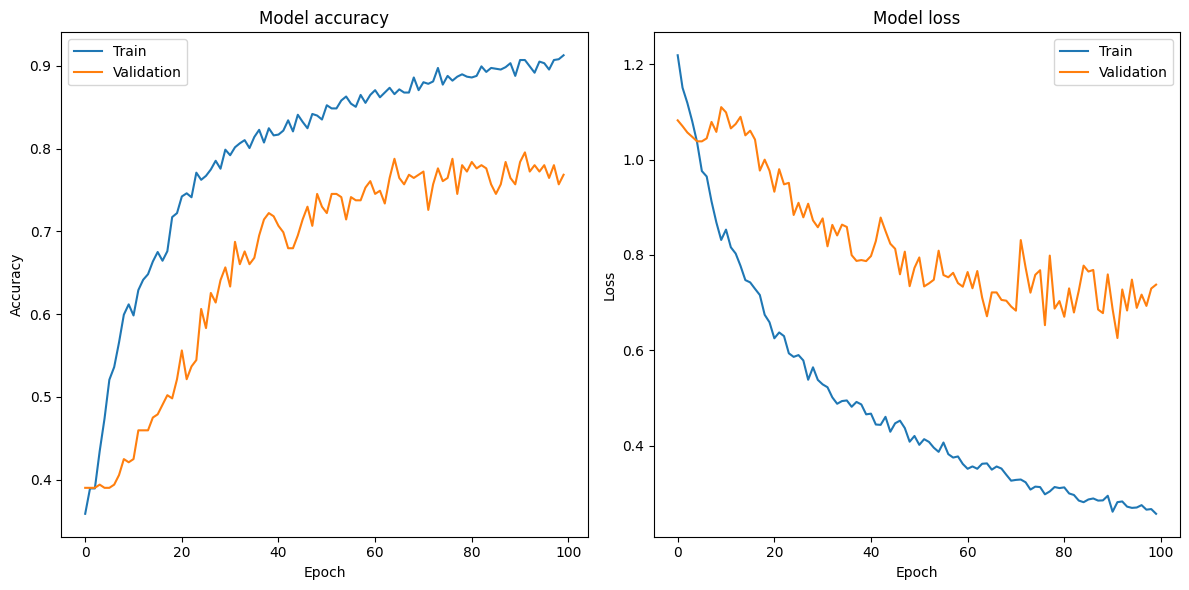

In [ ]:
# Step 8: Plotting accuracy and loss graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

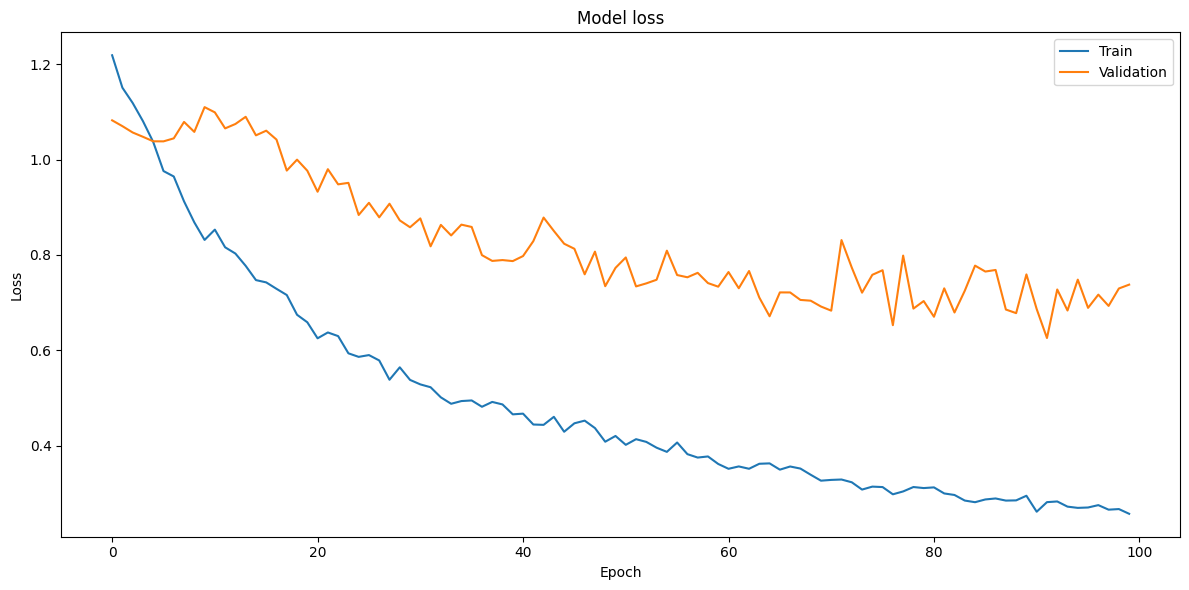

In [ ]:
# Step 9: Plotting loss only graph
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()